# Data Transmission over a Telephone Channel

In this notebook we will use the telephone channel model we derived in the previous notebook to see the effects of the channel over simple data transmission schemes.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import IPython
import scipy.sparse as ss
import scipy.signal as sp

In [2]:
# the clock of out system
SF = 24000

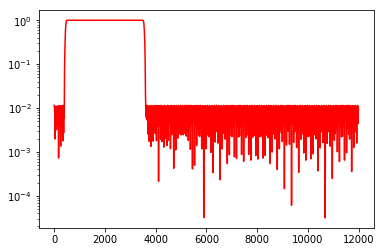

In [3]:
wa = 500.0 / (SF/2)
wb = 3500.0 / (SF/2)
wd = 100. / (SF/2)
h=sp.remez(600, [0, wa-wd, wa, wb, wb+wd, 1], [0, 1, 0], [1, 10, 1], Hz=2, maxiter=50)

# quick check
w, H = sp.freqz(h, worN=1024)
H = np.abs(H)
plt.semilogy(w/np.pi * (SF/2), H, 'red');

Now let's build a binary random data signal. We will balance it so that for each "1" bit we will encode a "1" and for each "0" we will encode a "-1":

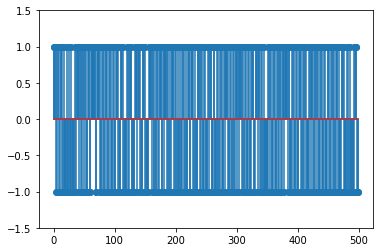

In [4]:
BITS = 500
b = np.sign(np.random.randn(BITS,1))

plt.stem(b);
plt.ylim([-1.5, 1.5]);

## Naive transmission

Let's try to send out the signal as-is: 
 * decide on the number of bits per second we transmit (BPS)
 * find out the corresponding samples per bit (SPB)
 * for each bit in the sequence, send out SPB samples equal to +1 or -1 accordingly

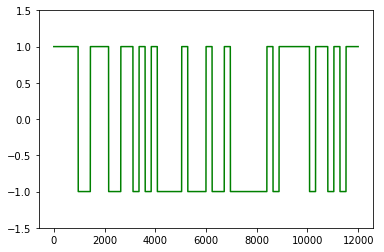

In [5]:
BPS = 100
SPB = int(SF / BPS)
# build the signal by column-row multiplication
x = (b * np.ones([1, SPB])).flatten()

# now let's look at the signal; easier to just look at the first 50 bits or so
plt.plot(x[0:SPB*50], 'green')
plt.ylim([-1.5, 1.5]);

We can try and listen to the signal we just generated. Already from the sound of it we can anticipate trouble... (can you guess why?)

In [6]:
IPython.display.Audio(x, rate=SF)

Let's trasnmit it over the telephone line and see what we receive:

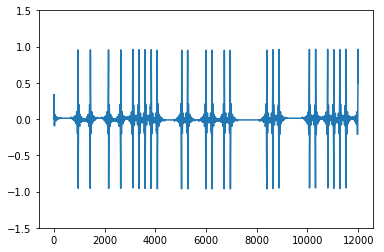

In [7]:
y = np.convolve(x, h, 'same')
plt.plot(y[0:SPB*50])
plt.ylim([-1.5, 1.5]);

This looks very different from what we transmitted! If we superimpose transmitted and received signals, here's what we get. Please note that we don't have to explicitly compensate for the delay introduced by the FIR filter since we used the `'same'` option in the `convolve()` function.

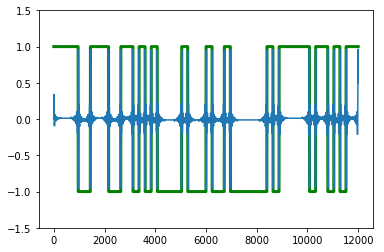

In [8]:
plt.plot(x[0:SPB*50], 'g', linewidth=3.0)
plt.plot(y[0:SPB*50])
plt.ylim([-1.5, 1.5]);

OK, so transmitted and received signals do have their transitions aligned. What's lost in the received signal are the steady portions of the signals between transitions. This loss would make it much harder to decode the received signal. In fact, the only information that we can exploit in this case is the sign of the transition. We can see this if we zoom in some more

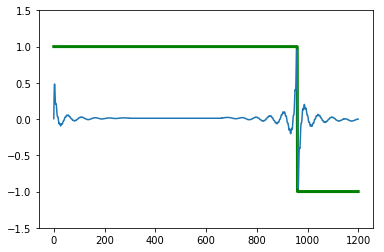

In [9]:
plt.plot(x[0:SPB*5], 'g', linewidth=3.0)
plt.plot(y[0:SPB*5])
plt.ylim([-1.5, 1.5]);

You can see that for a -1 to +1 transition in the transmitted signal, the received signal shows a "wiggle" that first goes negative then positive. The opposite happens for +1 to -1 transitions in the original signal. Decoding the received signal based on the shape of the wiggle is very inconvenient and fragile. 

To understand what's happening, let's look at the frequency domain:

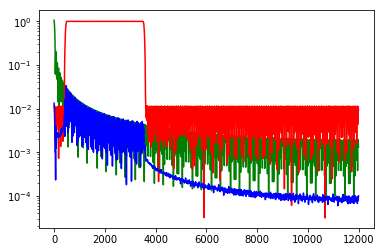

In [10]:
N = len(w)
X = np.abs(np.fft.fft(x, 2*N))
X = X[0:N];

plt.semilogy(w/np.pi * (SF/2), X/N, 'green')
plt.semilogy(w/np.pi * (SF/2), H, 'red');

Y = np.abs(np.fft.fft(y, 2*N))
Y = Y[0:N];
plt.semilogy(w/np.pi * (SF/2), Y/N, 'blue');

As you can see, the problem is trying to send a signal with a strong low frequency content over a bandpass channel: the channel kills the low frequencies and, therefore, annihilate the flat regions of the signal in the time domain. Because of this mismatch between channel and signal, communication would be problematic.

## Frequency-Shift Keying (FSK)

To accomodate the bandpass nature of the channel, a common communication strategy is to use FSK. In this signaling scheme, two frequencies $\omega_0$ and $\omega_1$ are used and, for each bit, we ouptut SPB samples of a sinusoid at frequency either $\omega_0$ or $\omega_1$ according to the value of the bit.

In [11]:
# frequencies must be in the telephone band: 500Hz to 3500Hz
# let's pick these
f0 = 1000
f1 = 2000

# we're using these frequencies to generate digital sinusoids, so convert them into the digital domain 
# note we're multiplying by pi since these are not Python-normalized quantities
w0 = np.pi * f0 / (SF/2)
w1 = np.pi * f1 / (SF/2)

In [12]:
# let's build the signal: transform the bit sequence into sequence of frequencies
#  (must be a column vector)
bw = np.array([w0 if v == -1 else w1 for v in b])[:,None]

# now associate BPS samples to each bit
x = (bw * np.ones([1, SPB])).flatten()

# and now build the FSK signal
x = np.cos(np.arange(0, len(x)) * x)

If we look at the signal (we need to enlarge the size of the plot a bit to see the details) we can notice regions at lower and higher frequencies:

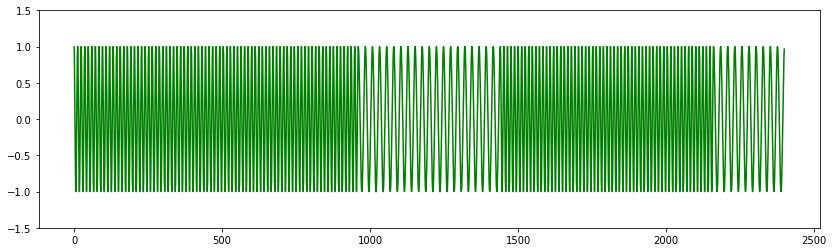

In [13]:
plt.figure(figsize=(14,4))
plt.plot(x[0:SPB*10], 'green')
plt.ylim([-1.5, 1.5]);

We can also listen to the signal. If it sounds familiar, it's because FSK was (is) the data encoding method used in Fax machines (you may have seen one in a movie at least!) 

In [14]:
IPython.display.Audio(x, rate=SF)

If we now send the sequence over the telephone channel, not much changes. We can verify that acoustically and then look at the spectrum: clearly most of the energy content of the transmitted signal is within the telephone band:

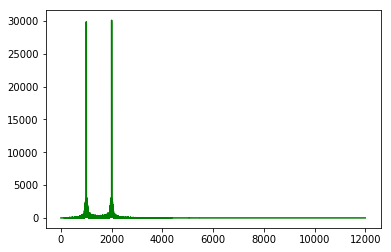

In [15]:
X = np.abs(np.fft.fft(x))
N = int(len(X)/2)
plt.plot(np.linspace(0,1,N) * (SF/2), X[0:N], 'green');

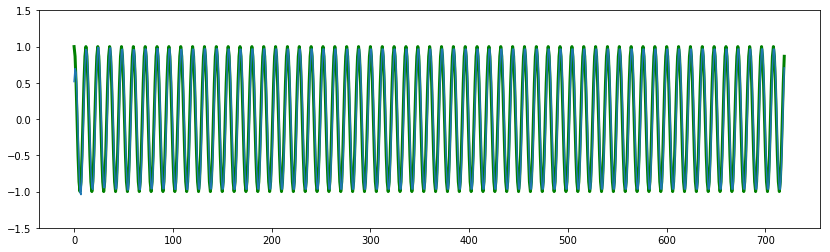

In [16]:
# now pass it thru the "telephone"
y = np.convolve(x, h, 'same')

# plotting original and received shows little difference:
plt.figure(figsize=(14,4))
plt.plot(x[0:SPB*3], 'g', linewidth=3.0)
plt.plot(y[0:SPB*3])
plt.ylim([-1.5, 1.5]);

In [17]:
# and it sounds the same
IPython.display.Audio(y, rate=SF)

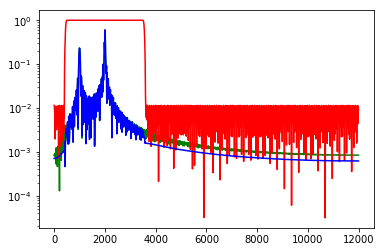

In [18]:
# finally, let's check the spectrum like before:
N = len(w) # use the same number of points as the filter's frequency response
X = np.abs(np.fft.fft(x, 2*N))
X = X[0:N]

plt.semilogy(w/np.pi * (SF/2), X/N, 'green')
plt.semilogy(w/np.pi * (SF/2), H, 'red');

Y = np.abs(np.fft.fft(y, 2*N));
Y = Y[0:N];
plt.semilogy(w/np.pi * (SF/2), Y/N, 'blue');

## Conclusions

Of course we haven't shown how to *decode* the FSK signal but, given that it doesn't get distorted by the channel, the job should be easier than in the naive transmission case.

The bottom line is: when designing a communication system, the first rule is to fit the signal to the channel.